## DSCI 100 Project Proposal Team 44

# Project Title: Predicting Heart Disease in Adults

## Introduction

### Background

### Predictor selection


## Methods & Results

In [1]:
#Load libraries
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### Load & Format data

In [35]:
set.seed(800)

#Read data in from UCI website
data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")

#Add column names
attributes <-  c("age", 'sex','cp', 'trestbps', 'chol', 'fbs', 'restecg',
                 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num')
colnames(data) <- attributes

#Remove NA values and reformat data types to correct type
data <- data %>%
  mutate(oldpeak = as.numeric(oldpeak),
         ca = as.numeric(ca),
         thal = as.numeric(thal)) %>% 
  filter(!is.na(ca),
         !is.na(thal))

#Remove categorial predictors 
data <-  data %>% 
    select(-c(cp, fbs, restecg, exang, slope, thal))

#Convert the prediction label into a factor
data <- data %>%
  mutate(num = ifelse(num > 0,"disease","healthy")) %>% 
  mutate(num = as_factor(num)) 

head(data)

Warning message:
“Duplicated column names deduplicated: '1.0' => '1.0_1' [3], '1.0' => '1.0_2' [6], '0.0' => '0.0_1' [12]”
Parsed with column specification:
cols(
  `63.0` = col_double(),
  `1.0` = col_double(),
  `1.0_1` = col_double(),
  `145.0` = col_double(),
  `233.0` = col_double(),
  `1.0_2` = col_double(),
  `2.0` = col_double(),
  `150.0` = col_double(),
  `0.0` = col_double(),
  `2.3` = col_double(),
  `3.0` = col_double(),
  `0.0_1` = col_character(),
  `6.0` = col_character(),
  `0` = col_double()
)

Warning message:
“Problem with `mutate()` input `ca`.
ℹ NAs introduced by coercion
ℹ Input `ca` is `as.numeric(ca)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `thal`.
ℹ NAs introduced by coercion
ℹ Input `thal` is `as.numeric(thal)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


age,sex,trestbps,chol,thalach,oldpeak,ca,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
67,1,160,286,108,1.5,3,disease
67,1,120,229,129,2.6,2,disease
37,1,130,250,187,3.5,0,healthy
41,0,130,204,172,1.4,0,healthy
56,1,120,236,178,0.8,0,healthy
62,0,140,268,160,3.6,2,disease


In [36]:
#Stratefy data by gender
female_data <- data %>% 
    filter(sex == 0) %>% 
    select(-sex)

male_data <- data %>% 
    filter(sex == 1) %>% 
    select(-sex)

head(female_data)
head(male_data)

age,trestbps,chol,thalach,oldpeak,ca,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
41,130,204,172,1.4,0,healthy
62,140,268,160,3.6,2,disease
57,120,354,163,0.6,0,healthy
56,140,294,153,1.3,0,healthy
48,130,275,139,0.2,0,healthy
58,150,283,162,1.0,0,healthy


age,trestbps,chol,thalach,oldpeak,ca,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
67,160,286,108,1.5,3,disease
67,120,229,129,2.6,2,disease
37,130,250,187,3.5,0,healthy
56,120,236,178,0.8,0,healthy
63,130,254,147,1.4,1,disease
53,140,203,155,3.1,0,disease


In [41]:
set.seed(800)

#Create the training and testing data sets
heart_split <- initial_split(female_data, prop = 0.8, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)    

# heart_split_f <- initial_split(female_data, prop = 0.8, strata = num)
# heart_train_f <- training(heart_split_f)
# heart_test_f <- testing(heart_split_f)   

## Determine which predictors produce a more accurate model for each gender

In [42]:
set.seed(800)

#Predictor columns
names <- colnames(heart_train %>% select(-num))

#Tibble to store accuracies:
accuracies <- tibble(size = integer(),
                     model_string = character(),
                     accuracy = numeric())

#create a model spec
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) %>%
  set_engine("kknn") %>% 
  set_mode("classification")

#Create a 5-fold cross-validation object
heart_vfold <- vfold_cv(heart_train,
                        v = 5,
                        strata = num)

#Store the total number of predictors 
n_total <- length(names)

#Store selected predictors
selected <- c()

#Check variables
n_total
names


[1] 6

[1] "age"      "trestbps" "chol"     "thalach"  "oldpeak"  "ca"

In [43]:
set.seed(800)
for (i in 1:n_total) {
  accs <- list()
  models <- list()
  for (j in names){
    preds_new <- c(selected, j)
    model_string <- paste("num", "~", paste(preds_new, collapse = '+'))
    
    #Create recipe from model string
    heart_recipe <- recipe(as.formula(model_string),
                            data = heart_train) %>% 
      step_scale(all_predictors()) %>% 
      step_center(all_predictors())
    
    #Tune KNN classifier with these predictors
    #collect accuracy for best k
    
    acc <- workflow() %>% 
      add_recipe(heart_recipe) %>% 
      add_model(knn_spec) %>% 
      tune_grid(resamples = heart_vfold, grid = 10) %>% 
      collect_metrics() %>% 
      filter(.metric == "accuracy") %>% 
      summarise(mx = max(mean))
    acc <- acc$mx %>% unlist()
    
    #add result to dataframe
    accs[[j]] <- acc
    models[[j]] <- model_string
  }
  jstar <- which.max(unlist(accs))
  accuracies <- accuracies %>% 
    add_row(size = i, 
            model_string = models[[jstar]], 
            accuracy = accs[[jstar]])
  selected <- c(selected, names[[jstar]])
  names <- names[-jstar]
}

In [44]:
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,num ~ oldpeak,0.7821078
2,num ~ oldpeak+age,0.8330392
3,num ~ oldpeak+age+ca,0.7845098
4,num ~ oldpeak+age+ca+trestbps,0.7954412
5,num ~ oldpeak+age+ca+trestbps+chol,0.7687745
6,num ~ oldpeak+age+ca+trestbps+chol+thalach,0.7554412


Only numerical predictors  
 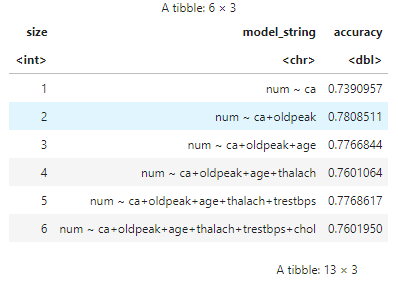  
Only numerical + binary categorical predictors  
 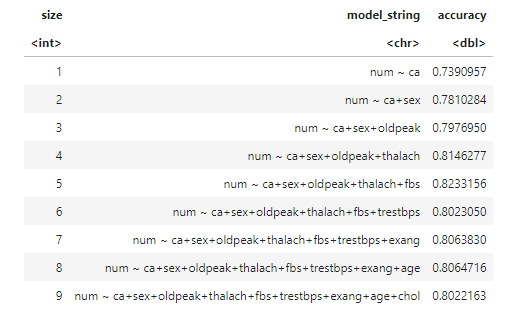  
Only female numerical  
 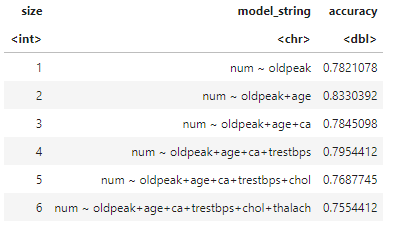  
Only male numerical  
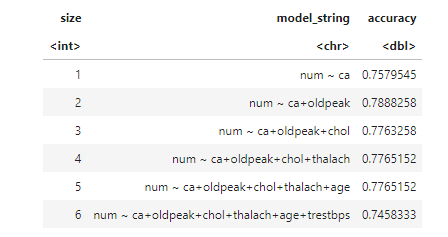



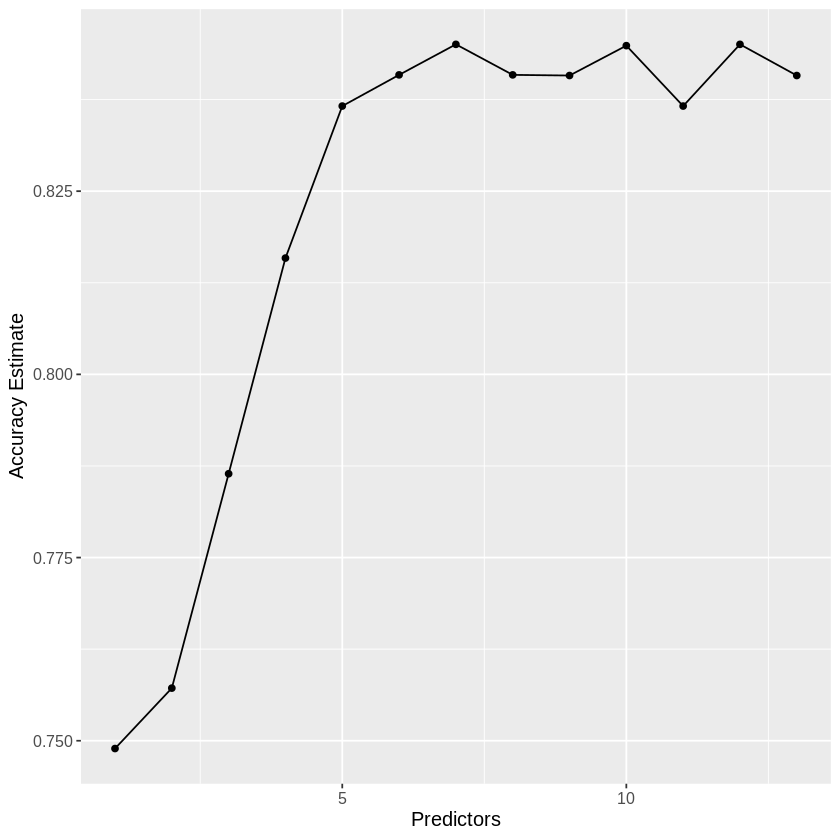

In [30]:
accuracy <- ggplot(accuracies, aes(x = size, y = accuracy)) +
  geom_point() +
  geom_line() +
  labs(x = "Predictors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))
accuracy

# Build the model with the selected predictors 

In [47]:
set.seed(800)

forward_recipe <- recipe(num ~ thal+thalach+ca+cp+exang+chol+trestbps,
                         data = heart_train) %>% 
  step_scale(all_predictors()) %>% 
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

heart_vfold <- vfold_cv(heart_train,
                        v = 5,
                        strata = num)

knn_results_fs <- workflow() %>% 
  add_recipe(forward_recipe) %>% 
  add_model(knn_spec) %>% 
  tune_grid(resamples = heart_vfold, grid = 10) %>% 
  collect_metrics() 

accuracies_fs <- knn_results_fs %>% 
  filter(.metric == "accuracy")
accuracies_fs

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7112589,5,0.02328778,Model1
4,accuracy,binary,0.7697695,5,0.05199217,Model2
5,accuracy,binary,0.7825355,5,0.03568926,Model3
7,accuracy,binary,0.7908688,5,0.03077640,Model4
9,accuracy,binary,0.8034574,5,0.02973647,Model5
10,accuracy,binary,0.8034574,5,0.02973647,Model6
12,accuracy,binary,0.8076241,5,0.02205514,Model7
13,accuracy,binary,0.8076241,5,0.02569125,Model8
14,accuracy,binary,0.8076241,5,0.02569125,Model9


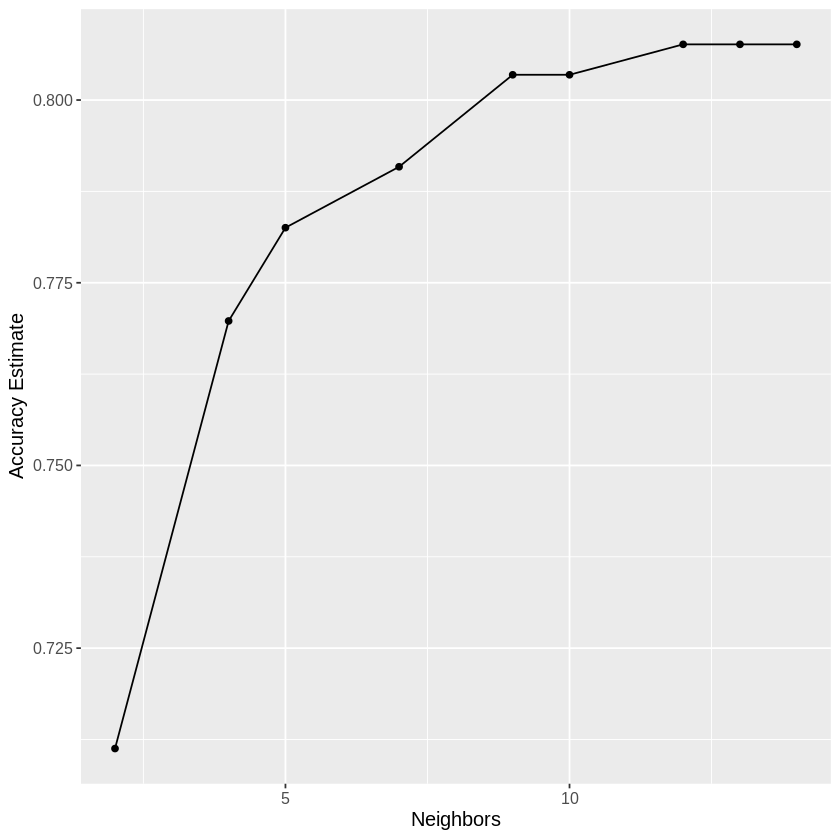

In [48]:
accuracy_vs_n <- ggplot(accuracies_fs, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))
accuracy_vs_n

13 Neighbors chosen due to stability in accuracy measurement 

In [51]:
knn_spec_rt <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

knn_fit_rt <- workflow() %>% 
  add_recipe(forward_recipe) %>% 
  add_model(knn_spec_rt) %>% 
  fit(data = heart_train)


In [52]:
heart_train_predictions <- predict(knn_fit_rt, heart_train) %>% 
  bind_cols(heart_train)

heart_metrics_train <- heart_train_predictions %>% 
  metrics(truth = num, estimate = .pred_class) %>% 
  filter(.metric == "accuracy")

#heart_test_predictions
heart_metrics_train

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.832636


## Predict Model accuracy on testing data

In [53]:
heart_test_predictions <- predict(knn_fit_rt, heart_test) %>% 
  bind_cols(heart_test)

heart_metrics_test <- heart_test_predictions %>% 
  metrics(truth = num, estimate = .pred_class) %>% 
  filter(.metric == "accuracy")

#heart_test_predictions
heart_metrics_test

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8448276


In [50]:
#Confusion matrix 

confusion <- heart_test_predictions %>% 
             conf_mat(truth = num , estimate = .pred_class)

confusion

          Truth
Prediction healthy disease
   healthy      27       5
   disease       4      22